# Signal Fitting
This notebook shows how the double crystal ball function was fit to the signal mass distribution. It was fitted separately for the control and rare decay modes. 

In [1]:
# All the necessary imports
import tensorflow as tf
import zfit
from zfit import z
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep

# Set the plotting style for consistency
plt.style.use([hep.style.ROOT, hep.style.firamath])

2022-06-01 10:12:54.742113: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-01 10:12:54.742180: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/user211/envs/scientific/lib64/python3.9/site-packages/zfit/__init__.py:37: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn("TensorFlow warnings are by default suppressed by zfit."


## Load Data
Does what it says on the tin, fetches the relevant modes CSV file.

In [2]:
useNormalisation = False

# For more information on these files, see the outputs/csv_metadata files
if useNormalisation:
    v = "8.0.1"
else:
    v = "9.0.1"

# Read in the CSVs ignoring the index column
pre = pd.read_csv(f'../data_files/{v}/all.csv', index_col=[0])

# Take the Lb_M variable for all signal events (category == 1) and cast to a numpy array
pre = pre['Lb_M'][pre['category']==1].to_numpy()

# Restrict the mass region our observations fall into i.e. 4500 < m < 6500 MeV
pre = pre[np.logical_and(pre < 6500, pre > 4500)]

## Plot Distributions
Do a basic visual inspection on the data before we go to try and fit it.

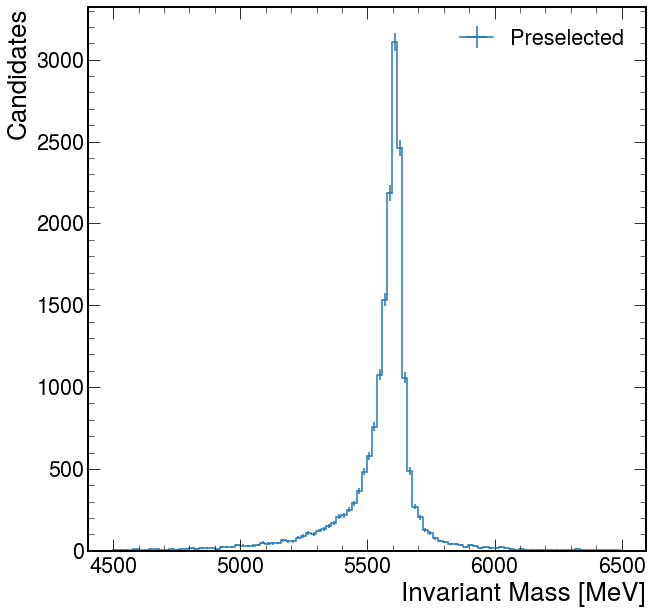

In [3]:
# Generate a histogram from the numpy array above
fpre, bins = np.histogram(pre, bins=100)

# Plot the histogram
fig, ax = plt.subplots(1, 1)

# yerr=True computes sqrt{N}
hep.histplot(fpre, yerr=True, bins=bins, ax=ax, label='Preselected')

plt.xlabel('Invariant Mass [MeV]')
plt.ylabel('Candidates')
plt.legend()
plt.show()

In [4]:
# Create a function for fitting the DoubleCB inside of zfit to help avoid NameAlreadyTaken errors
def fitDoubleCB(np_data, label, mass_ranges=[4000, 6500], param_ranges=[[5600, 5500, 5700],[20, 10, 50],[1, 0, 2],[4, 0.1, 10],[1, 0, 2],[4, 0.1, 10],[30000, 0, 100000]]):
    massObsMC = zfit.Space("Lb_M", limits=(mass_ranges[0], mass_ranges[1]))
    MC_LbM = zfit.Data.from_numpy(obs=massObsMC, array=np_data)
    
    mu_CB = zfit.Parameter('mu_CB_%s'%label, *param_ranges[0])
    sigma_CB = zfit.Parameter('sigma_CB_%s'%label, *param_ranges[1])
    alpha_l = zfit.Parameter('alpha_l_%s'%label, *param_ranges[2])
    n_l = zfit.Parameter('n_l_%s'%label, *param_ranges[3])
    alpha_r = zfit.Parameter('alpha_r_%s'%label, *param_ranges[4])
    n_r = zfit.Parameter('n_r_%s'%label, *param_ranges[5])
    
    dcb = zfit.pdf.DoubleCB(obs=massObsMC, mu=mu_CB, sigma=sigma_CB, alphal=alpha_l, nl=n_l, alphar=alpha_r, nr=n_r)
    
    dcb_yield = zfit.Parameter('DCB_yield_%s'%label, *param_ranges[6], step_size=1)
    dcb_ext = dcb.create_extended(dcb_yield)
    nll_ext_dcb = zfit.loss.ExtendedUnbinnedNLL(dcb_ext, MC_LbM)
    minimizerDCB = zfit.minimize.Minuit(use_minuit_grad=True)
    fitResult = minimizerDCB.minimize(nll_ext_dcb)
    
    return dcb_ext, fitResult, MC_LbM

In [5]:
# Call the fitting function and try to minimise
pmodel, presult, pmasses = fitDoubleCB(pre, "0", mass_ranges=[4500, 6500])

# Display whether the fit was okay, e.g. did the result converge and is it a valid minima
print(f"\nPreselection\n============\nResult Converged: {presult.converged}\nResult Valid: {presult.valid}")

2022-06-01 10:18:55.705645: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-01 10:18:55.705758: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-01 10:18:55.705805: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (eprexb.ph.bham.ac.uk): /proc/driver/nvidia/version does not exist
2022-06-01 10:18:55.765890: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-01 10:18:57.585950: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of th


Preselection
Result Converged: True
Result Valid: True


In [6]:
# Generate errors on the parameters, then print them all to the console
p_param_errors = presult.errors()
print(presult.params)

# You can also display them at full length using the code below
#for key, value in presult.params.items():
#    print(f"{key.name} = {value['value']}+-({value['minuit_minos']['upper']},{value['minuit_minos']['lower']})")

/home/user211/envs/scientific/lib64/python3.9/site-packages/zfit/minimizers/fitresult.py:1115: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn("'minuit_minos' will be changed as the default errors method to a custom implementation"


name           value         minuit_minos    at limit
-----------  -------  -------------------  ----------
DCB_yield_0    18130  -1.3e+02   +1.4e+02       False
alpha_l_0     0.5261  -  0.024   +  0.023       False
alpha_r_0      1.248  -  0.045   +  0.044       False
mu_CB_0         5611  -   0.61   +   0.64       False
n_l_0          2.474  -  0.065   +  0.068       False
n_r_0          1.891  -  0.064   +  0.066       False
sigma_CB_0     22.75  -   0.89   +   0.85       False


Chi2 = 1.5887


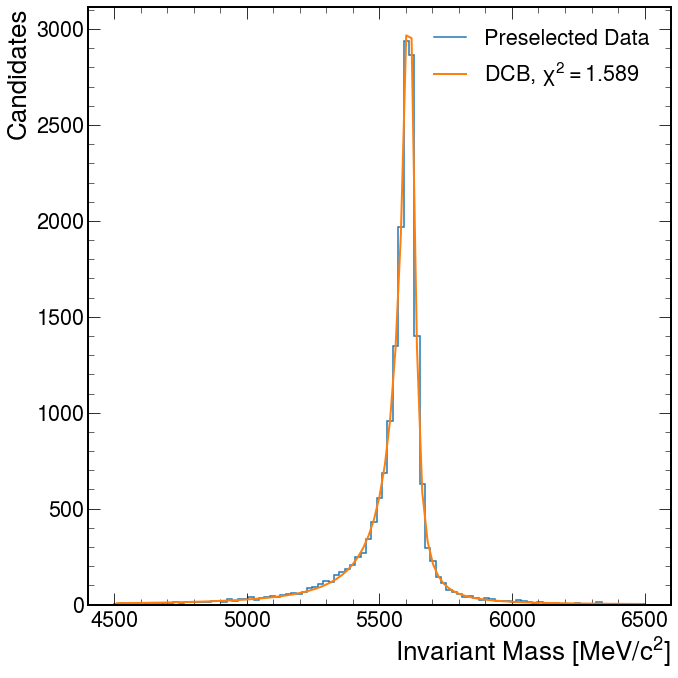

In [10]:
# Plot the results
fig, ax = plt.subplots(1, 1)
labels = ['Preselected Data', 'No Preselection']
i = 0

# This was originally used to plot multiple functions against data and preselected data at once hence the labels variable
# above and the zipping below. It is redundant now but acheives broadly the same thing
for model, data in zip([pmodel], [pmasses]):
    allLimits = [data.data_range.limit1d[0], data.data_range.limit1d[1]]
    allLimits = np.array(allLimits)

    xBins = np.linspace(np.amin(allLimits), np.amax(allLimits), num=100) 
    x = (xBins[1:]+xBins[:-1])/2
    y = np.array([])
    nBinsLimit=0
    for a in range(int(allLimits.shape[0]/2)):
        nBinsLimit += len(x[(x>allLimits[a*2])&(x<allLimits[a*2+1])])
    
    y = np.append(y, model.pdf(x) * data.nevents.numpy() / nBinsLimit * np.sum(allLimits[1::2]-allLimits[::2]))

    data_plot = zfit.run(z.unstack_x(data))

    h, _ = np.histogram(data_plot, bins=xBins)
    hep.histplot(h, bins=xBins, ax=ax, label=labels[i])
    
    scaledDiff=(h[h!=0]-y[h!=0])/np.sqrt(h[h!=0])
    
    chi2 = np.sum(scaledDiff**2)/(len(scaledDiff)-len(pmodel.get_params()))
    print("Chi2 = %.5g"%chi2)
    
    ax.plot(x, y, linewidth=2, label=rf'DCB, $\chi^2={chi2:.3f}$')

    
    i += 1
    
plt.ylabel('Candidates')
plt.xlabel(r'Invariant Mass [$MeV/c^2$]')
plt.legend()
plt.tight_layout()
plt.show()

# Normalisation Mode
The signal mode data in the control channel has slightly different constraints so it turns out this was actually easier to do separately. Renaming of all the variables here was horrific practice but this is what you are getting sorry.

## Load Data

In [12]:
pre = pd.read_csv('../data_files/8.0.0/all.csv', index_col=[0])
pre = pre[pre['QSQR'].between(3000, 3718)]
pre = pre['Lb_M'][pre['category']==1].to_numpy()
# Remember that Dan has already applied the pre-selection
pre = pre[np.logical_and(pre < 5800, pre > 5200)]

## Plot Data

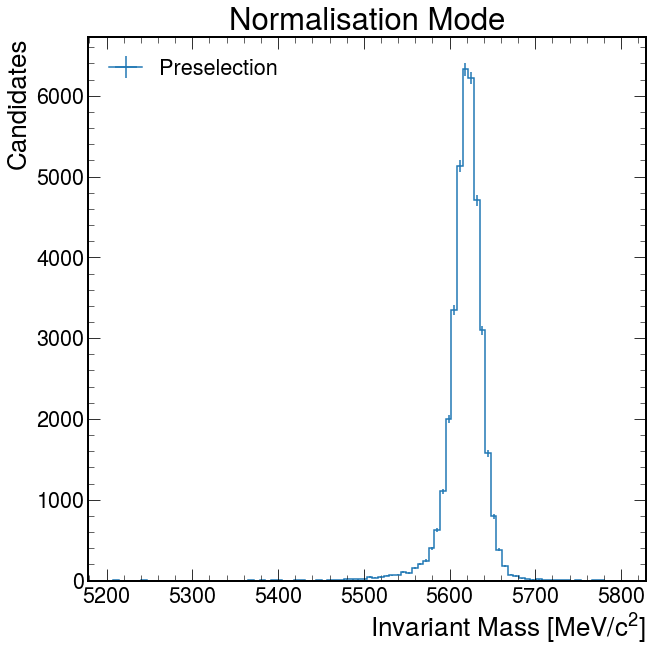

In [13]:
fpre, bins = np.histogram(pre, bins=90)
fig, ax = plt.subplots(1, 1)
hep.histplot(fpre, yerr=True, bins=bins, ax=ax, label='Preselection')
plt.xlabel(r'Invariant Mass [$MeV/c^2$]')
plt.ylabel('Candidates')
plt.legend()
plt.title('Normalisation Mode')
plt.show()

# Fit Data

In [11]:
model, result, space = fitDoubleCB(pre, 'Norm', mass_ranges=[5200, 5800])
print(f"\nPreselection\n============\nResult Converged: {result.converged}\nResult Valid: {result.valid}")


Preselection
Result Converged: True
Result Valid: True


In [12]:
param_errors = result.errors()
print(result.params)

/home/user211/envs/scientific/lib64/python3.9/site-packages/zfit/minimizers/fitresult.py:1115: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn("'minuit_minos' will be changed as the default errors method to a custom implementation"


name              value         minuit_minos    at limit
--------------  -------  -------------------  ----------
DCB_yield_Norm    16910  -1.3e+02   +1.3e+02       False
alpha_l_Norm     0.5833  -  0.029   +   0.03       False
alpha_r_Norm      1.263  -  0.064   +  0.067       False
mu_CB_Norm         5610  -   0.62   +   0.62       False
n_l_Norm          2.152  -  0.099   +   0.11       False
n_r_Norm          1.973  -   0.19   +   0.21       False
sigma_CB_Norm     23.38  -   0.89   +   0.89       False


Chi2 = 1.58875


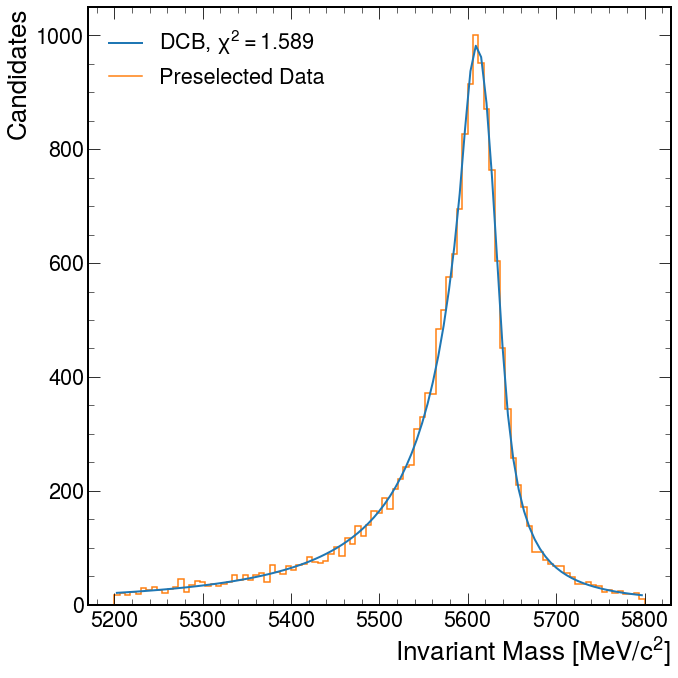

In [13]:
fig, ax = plt.subplots(1, 1)
labels = ['Preselected Data', 'No Preselection']
i = 0

for model, data in zip([model], [space]):
    allLimits = [data.data_range.limit1d[0], data.data_range.limit1d[1]]
    allLimits = np.array(allLimits)

    xBins = np.linspace(np.amin(allLimits), np.amax(allLimits), num=100) 
    x = (xBins[1:]+xBins[:-1])/2
    y = np.array([])
    nBinsLimit=0
    for a in range(int(allLimits.shape[0]/2)):
        nBinsLimit += len(x[(x>allLimits[a*2])&(x<allLimits[a*2+1])])
    
    y = np.append(y, model.pdf(x) * data.nevents.numpy() / nBinsLimit * np.sum(allLimits[1::2]-allLimits[::2]))

    chi2=np.sum(scaledDiff**2)/(len(scaledDiff)-len(model.get_params()))
    ax.plot(x, y, linewidth=2, label=rf'DCB, $\chi^2={chi2:.3f}$')
    data_plot = zfit.run(z.unstack_x(data))

    h, _ = np.histogram(data_plot, bins=xBins)
    hep.histplot(h, bins=xBins, ax=ax, label=labels[i])

    scaledDiff=(h[h!=0]-y[h!=0])/np.sqrt(h[h!=0])
    
    print("Chi2 = %.6g"%chi2)
    i += 1
    
plt.ylabel('Candidates')
plt.xlabel(r'Invariant Mass [$MeV/c^2$]')
plt.legend()
plt.tight_layout()
plt.show()